In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from xgboost import XGBRegressor

In [2]:
# Load the dataset
file_path = "streamed_kafka_data.csv"  # Replace with your file path
df = pd.read_csv(file_path)
print(df.shape)

(9471, 14)


In [3]:
df = df.drop(columns=['NMHC(GT)'])

In [7]:
df.replace({'NaT': np.nan}, inplace=True)

# List of numeric columns to clean
numeric_cols = ['CO(GT)', 'NOx(GT)', 'C6H6(GT)']

# Loop through each column and clean data
for col in numeric_cols:
    # Ensure column is float type (to handle NaN values)
    df[col] = df[col].astype(float)

    # Replace infinite values with NaN
    df[col].replace([float('inf'), float('-inf')], np.nan, inplace=True)

C:\Users\HP\AppData\Local\Temp\ipykernel_29884\1456620561.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].replace([float('inf'), float('-inf')], np.nan, inplace=True)
C:\Users\HP\AppData\Local\Temp\ipykernel_29884\1456620561.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as 

In [12]:
# Convert 'Datetime' column to datetime format and set it as the index
df['Datetime'] = df['Datetime'].str.strip() 
df['Datetime'] = pd.to_datetime(df['Datetime'], errors='coerce')
df.set_index('Datetime', inplace=True)
available_years = df.index.year.unique()
available_years

Index([2004.0, 2005.0, nan], dtype='float64', name='Datetime')

In [14]:
# Drop rows with missing values in the target column (e.g., 'CO(GT)')
df = df.dropna(subset=['CO(GT)'])
print(df.shape)
available_years = df.index.year.unique()
available_years

(7674, 12)


Index([2004, 2005], dtype='int32', name='Datetime')

In [16]:
# --- Feature Engineering ---

# 1. Time-based features
df['Hour'] = df.index.hour  # Extract hour from datetime
df['Day'] = df.index.day    # Extract day from datetime
df['Month'] = df.index.month  # Extract month from datetime

In [18]:
# 2. Lagged features (previous time periods)
for lag in range(1, 4):  # Create lagged features for 1, 2, and 3 previous periods
    df[f'CO_lag_{lag}'] = df['CO(GT)'].shift(lag)
    df[f'NOx_lag_{lag}'] = df['NOx(GT)'].shift(lag)
    df[f'C6H6_lag_{lag}'] = df['C6H6(GT)'].shift(lag)

In [20]:
# 3. Rolling statistics (averages and standard deviations)
rolling_window = 3  # Define rolling window size (e.g., 3 periods)
df['CO_roll_mean'] = df['CO(GT)'].rolling(window=rolling_window).mean()
df['CO_roll_std'] = df['CO(GT)'].rolling(window=rolling_window).std()
df['NOx_roll_mean'] = df['NOx(GT)'].rolling(window=rolling_window).mean()
df['NOx_roll_std'] = df['NOx(GT)'].rolling(window=rolling_window).std()

In [22]:
# Drop rows with NaN values introduced by lagged/rolling features
df.dropna(how='all',inplace=True)
print(df.shape)
available_years = df.index.year.unique()
available_years

(7674, 28)


Index([2004, 2005], dtype='int32', name='Datetime')

In [24]:
df.head()

,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,...,CO_lag_2,NOx_lag_2,C6H6_lag_2,CO_lag_3,NOx_lag_3,C6H6_lag_3,CO_roll_mean,CO_roll_std,NOx_roll_mean,NOx_roll_std
Datetime,,,,,,,,,,,,,,,,,,,,,
2004-03-10 18:00:00,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-03-10 19:00:00,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2004-03-10 20:00:00,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,...,2.6,166.0,11.9,NaN,NaN,NaN,2.266667,0.305505,133.333333,31.564748
2004-03-10 21:00:00,2.2,1376.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,...,2.0,103.0,9.4,2.6,166.0,11.9,2.133333,0.115470,135.333333,34.703506
2004-03-10 22:00:00,1.6,1272.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,...,2.2,131.0,9.0,2.0,103.0,9.4,2.000000,0.346410,144.666667,23.671361


In [26]:
#df.index = pd.to_datetime(df.index)

#print("Available years in dataset:", df.index.year.unique())

In [28]:
train_df = df[df.index.year == 2004.0]  # All 2004 data
print(train_df.shape)
test_df = df[df.index.year == 2005.0]   # All 2005 data
print(test_df.shape)

(5526, 28)
(2148, 28)


In [30]:
#test_df.to_csv('AirQualityUCI_2025.csv')

In [32]:
# --- Train/Test Split ---

# Chronological split for time series data (no random shuffling)
#train_size = int(0.8 * len(df))  # Use 80% of the data for training
#train_df = df.iloc[:train_size]
#test_df = df.iloc[train_size:]

In [34]:
# Check for common indices between train and test
common_indices = train_df.index.intersection(test_df.index)

if len(common_indices) > 0:
    print(f"There are {len(common_indices)} overlapping indices between train and test sets.")
    print("Overlapping indices:", common_indices)
else:
    print("No overlapping indices between train and test sets.")

# Optional: Check for overlapping rows (if indices differ but data matches)
common_rows = pd.merge(train_df, test_df, how='inner')

if not common_rows.empty:
    print(f"There are {len(common_rows)} overlapping rows between train and test sets.")
else:
    print("No overlapping rows between train and test sets.")

No overlapping indices between train and test sets.
No overlapping rows between train and test sets.


In [36]:
# Define features and target variable
features = ['Hour', 'Day', 'Month', 
            'CO_lag_1', 'CO_lag_2', 'CO_lag_3', 
            'NOx_lag_1', 'NOx_lag_2', 'NOx_lag_3',
            'C6H6_lag_1', 'C6H6_lag_2', 'C6H6_lag_3',
            'CO_roll_mean', 'CO_roll_std',
            'NOx_roll_mean', 'NOx_roll_std']

In [38]:
target = 'CO(GT)'  # Target variable: CO concentration

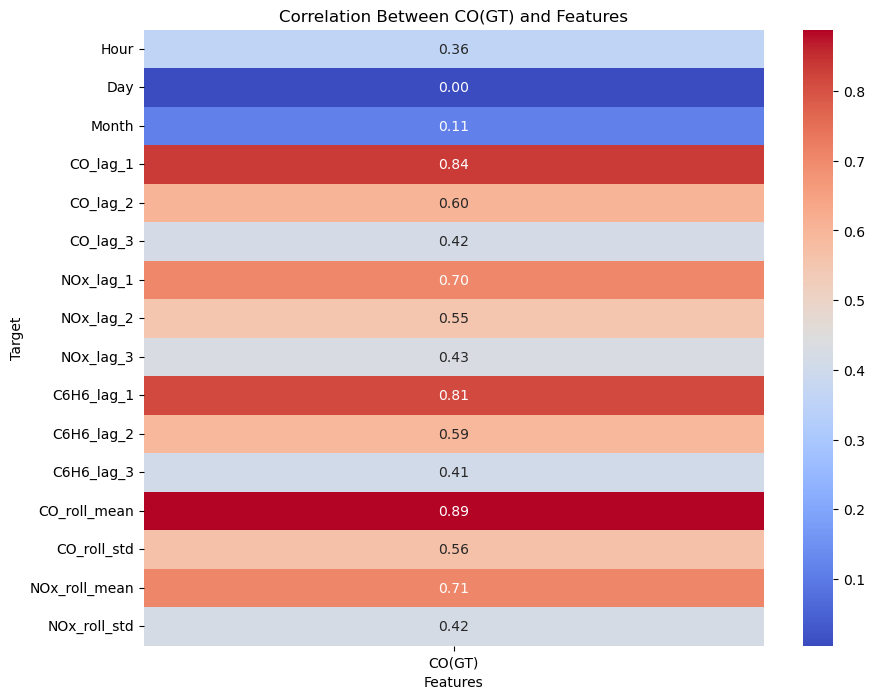

In [40]:
correlation_matrix = df[[target] + features].corr()

# Extract correlations of the target variable with features
target_correlations = correlation_matrix[target].drop(target)

# --- Visualization ---

plt.figure(figsize=(10, 8))
sns.heatmap(target_correlations.to_frame(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title(f"Correlation Between {target} and Features")
plt.xlabel("Features")
plt.ylabel("Target")
plt.show()

In [43]:
X_train, y_train = train_df[features], train_df[target]
X_test, y_test = test_df[features], test_df[target]

In [45]:
# Check for common indices between train and test
common_indices = X_train.index.intersection(X_test.index)

if len(common_indices) > 0:
    print(f"There are {len(common_indices)} overlapping indices between train and test sets.")
    print("Overlapping indices:", common_indices)
else:
    print("No overlapping indices between train and test sets.")

# Optional: Check for overlapping rows (if indices differ but data matches)
common_rows = pd.merge(X_train, X_test, how='inner')

if not common_rows.empty:
    print(f"There are {len(common_rows)} overlapping rows between train and test sets.")
else:
    print("No overlapping rows between train and test sets.")

No overlapping indices between train and test sets.
No overlapping rows between train and test sets.


In [48]:
#pip install xgboost

   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   - -------------------------------------- 5.2/150.0 MB 29.0 MB/s eta 0:00:05
   --- ------------------------------------ 13.4/150.0 MB 33.6 MB/s eta 0:00:05
   ----- ---------------------------------- 21.5/150.0 MB 35.7 MB/s eta 0:00:04
   ------- -------------------------------- 29.9/150.0 MB 37.2 MB/s eta 0:00:04
   --------- ------------------------------ 36.7/150.0 MB 35.9 MB/s eta 0:00:04
   ----------- ---------------------------- 44.6/150.0 MB 36.3 MB/s eta 0:00:03
   -------------- ------------------------- 53.2/150.0 MB 36.8 MB/s eta 0:00:03
   ---------------- ----------------------- 62.1/150.0 MB 37.4 MB/s eta 0:00:03
   ------------------ --------------------- 71.0/150.0 MB 38.1 MB/s eta 0:00:03
   --------------------- ------------------ 79.7/150.0 MB 38.5 MB/s eta 0:00:02
   ----------------------- ---------------- 88.1/150.0 MB 38.8 MB/s eta 0:00:02
   ------------------------- -------------- 97.0/1

In [47]:
# Initialize XGBoost regressor
xgb_model = XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1)

# Fit the model on training data
xgb_model.fit(X_train, y_train)

# Make predictions on test set
y_pred = xgb_model.predict(X_test)

# Evaluate model performance
mae = mean_absolute_error(y_test, y_pred)
rmse = sqrt(mean_squared_error(y_test, y_pred))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Mean Absolute Error (MAE): 0.11
Root Mean Squared Error (RMSE): 0.16


In [49]:
# --- Save the model to a pickle file ---
model_filename = "xgb_model.pkl"
with open(model_filename, "wb") as file:
    pickle.dump(xgb_model, file)

print(f"Model saved to {model_filename}")

Model saved to xgb_model.pkl


In [51]:
# Save model and feature list to a pickle file
model_metadata = {
    "model": xgb_model,
    "features": features
}
with open("xgb_model.pkl", "wb") as file:
    pickle.dump(model_metadata, file)

print("Model and features saved to xgb_model.pkl")

Model and features saved to xgb_model.pkl


In [53]:
# --- Load the model and feature list ---
with open("xgb_model.pkl", "rb") as file:
    model_metadata = pickle.load(file)
loaded_model = model_metadata["model"]
training_features = model_metadata["features"]

# --- Use the loaded model to score on new test data ---
# Ensure test data aligns with training features
X_test_aligned, _ = X_test.align(pd.DataFrame(columns=training_features), axis=1, fill_value=0)

# Make predictions on test set
y_pred_new_test = loaded_model.predict(X_test_aligned)

# Evaluate model performance
mae = mean_absolute_error(y_test, y_pred_new_test)
rmse = sqrt(mean_squared_error(y_test, y_pred_new_test))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")


Mean Absolute Error (MAE): 0.11
Root Mean Squared Error (RMSE): 0.16


Bonus question

ADF Statistic: -9.556031147206323
p-value: 2.4975917554606647e-16
Critical Values: {'1%': -3.4312065535348215, '5%': -2.8619185328129757, '10%': -2.5669714885183432}
The series is stationary.


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 CO(GT)   No. Observations:                 6139
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -7353.292
Date:                Tue, 08 Apr 2025   AIC                          14718.583
Time:                        19:29:32   BIC                          14758.917
Sample:                             0   HQIC                         14732.574
                               - 6139                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1829      0.009     21.480      0.000       0.166       0.200
ar.L2         -0.1681      0.010    -17.303      0.000      -0.187      -0.149
ar.L3         -0.1090      0.011     -9.492      0.0

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


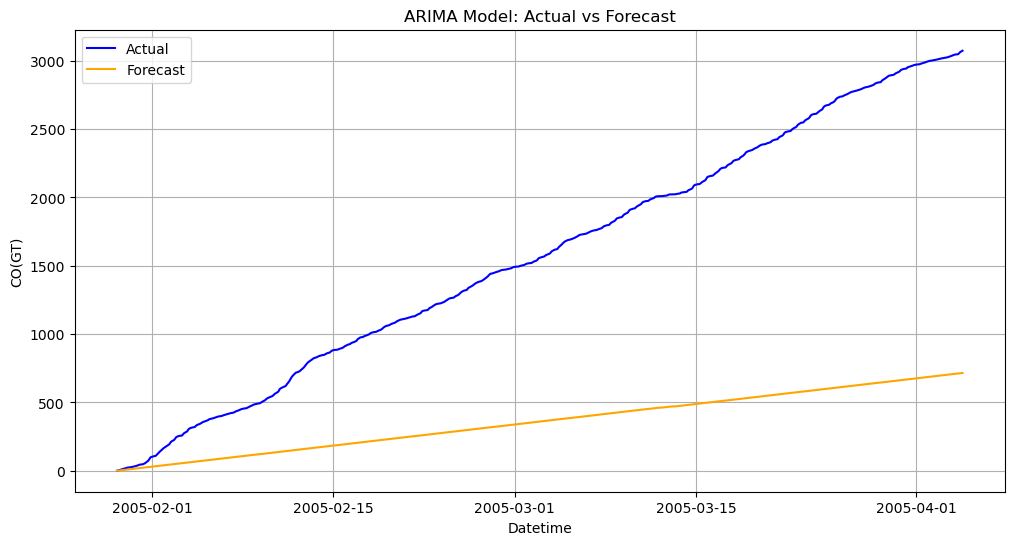

In [55]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

# Select the target variable (e.g., 'CO(GT)')
series = df['CO(GT)'].dropna()

# --- Check for Stationarity ---
def check_stationarity(series):
    result = adfuller(series)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    print("Critical Values:", result[4])
    if result[1] <= 0.05:
        print("The series is stationary.")
    else:
        print("The series is not stationary.")

check_stationarity(series)

# If the series is not stationary, apply differencing
if adfuller(series)[1] > 0.05:
    series_diff = series.diff().dropna()
    check_stationarity(series_diff)
else:
    series_diff = series


# --- Split Data into Train/Test Sets ---
train_size = int(0.8 * len(series_diff))  # Use 80% of the data for training
train, test = series_diff.iloc[:train_size], series_diff.iloc[train_size:]

# --- Determine ARIMA Parameters (p, d, q) ---
# Use ACF and PACF plots to determine p and q (manual tuning or use auto-arima)

# --- Fit ARIMA Model ---
model_order = (5, 1, 0)  # Replace with your chosen parameters (p, d, q)
model = ARIMA(train, order=model_order)
model_fit = model.fit()

print(model_fit.summary())

# --- Forecast on Test Set ---
forecast = model_fit.forecast(steps=len(test))
forecast_original_scale = forecast.cumsum() + series.iloc[train_size - 1]  # Reverse differencing

# --- Evaluate Model Performance ---
mae = mean_absolute_error(test.cumsum() + series.iloc[train_size - 1], forecast_original_scale)
rmse = sqrt(mean_squared_error(test.cumsum() + series.iloc[train_size - 1], forecast_original_scale))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# --- Plot Actual vs Predicted Values ---
plt.figure(figsize=(12, 6))
plt.plot(series.index[-len(test):], test.cumsum() + series.iloc[train_size - 1], label="Actual", color="blue")
plt.plot(series.index[-len(test):], forecast_original_scale, label="Forecast", color="orange")
plt.title("ARIMA Model: Actual vs Forecast")
plt.xlabel("Datetime")
plt.ylabel("CO(GT)")
plt.legend()
plt.grid(True)
plt.show()

Reference

All code was generated using AI

Chat history link - https://www.perplexity.ai/search/what-error-in-this-line-mean-b-tLbCAenpTJS59ZRnuLr5eQ